In [ ]:
""""
Koraci po redu:
1. Dodavanje biblioteka
2. Ucitavanje podataka
3. Provera koliko ima praznih podataka po kolonama
4. Overview podataka
5. Crtanje podataka
6. Trazenje korelacija izmedju podataka
7. Igranje sa podacima
8. Puno igranja sa podacima (Izbacivanje, modifikovanje)
9. Razdvajanje kolone koje pogadjamo i atributa (X i y) + Train test split 
10. Normalizacija
11. Kreiranje modela i dodavanje slojeva
12. Treniranje 
13. Evaluacija nakon treniranja (plotovanje podataka loss-ova) i analiza + ponovo igra sa podacima
14. Cross validacija
15. Predikcija
16. Evaluacija
"""

In [165]:
# 1. Dodavanje biblioteka
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score

#Proba sa jos nekim modelima
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [141]:
#Ucitavanje dataseta
df = pd.read_csv('TF_2_Notebooks_and_Data/DATA/lending_club_loan_two.csv')
df_info = pd.read_csv('TF_2_Notebooks_and_Data/DATA/lending_club_info.csv')

In [18]:
df_info

,LoanStatNew,Description
0,loan_amnt,The listed amount of the loan applied for by t...
1,term,The number of payments on the loan. Values are...
2,int_rate,Interest Rate on the loan
3,installment,The monthly payment owed by the borrower if th...
4,grade,LC assigned loan grade
5,sub_grade,LC assigned loan subgrade
6,emp_title,The job title supplied by the Borrower when ap...
7,emp_length,Employment length in years. Possible values ar...
8,home_ownership,The home ownership status provided by the borr...
9,annual_inc,The self-reported annual income provided by th...


In [121]:
df.head()
#dti, open_acc, int_rate,  pub_rec (mzd izbaciti), revol_bal, revol_util, application_type(mozda izbaciti), pub_rec_bankruptcies(mzd izbaciti), adress(mzd izbaciti)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [88]:
#Koje kolone dropujemo? emp_title, sub_grade, application_type


In [84]:
df.describe().transpose()
df['emp_title'].unique() #Jako mnogo razlicitih klasa (verovatno droppovati)
df['home_ownership'].value_counts() #6 razlicitih vrednosti (dosta neizbalansirano)
# df['application_type'].value_counts() #3 razlicite vrednosti (dosta neizbalansirano)
# df['grade'].value_counts() #7 razlicitih vrednosti ok izbalansirano
# df['sub_grade'].value_counts() #35 razlicitih vrednosti dosta izbalansirano (mozda izbaciti ove, a zadrzati ocene i njih pretvoriti u brojeve)
# df['verification_status'].value_counts() #Izbalansirane vrednosti mozda ih preveseti od 1 do 3 vrednosti

#Prvo cemo izbaciti ovaj red sa ANY, NONE i OTHER
# df = df[df['home_ownership'] != 'ANY']
# df = df[df['home_ownership'] != 'OTHER']
# df = df[df['home_ownership'] != 'NONE']
# df['home_ownership'].value_counts()
# #Mapiranje
# mapa = {'MORTGAGE':3, 'RENT':2, 'OWN':1}
# df['home_ownership'] = df['home_ownership'].map(mapa)

In [142]:
df.isnull().sum()
#Definitivno ima kolona i redova gde su null vrednosti

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1756
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [143]:
df = df.dropna() #Izbacio sam nekih 15% podataka

<Axes: xlabel='loan_status', ylabel='count'>

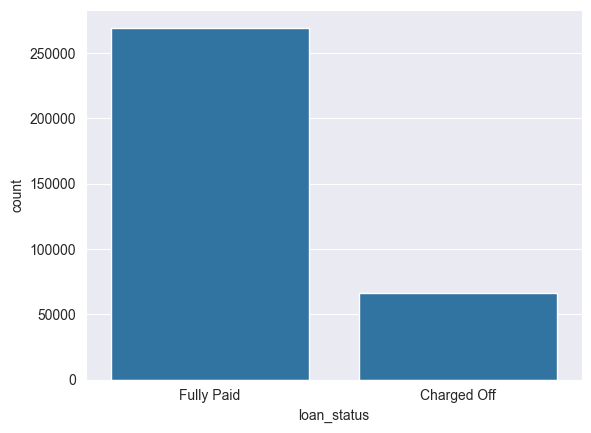

In [43]:
#Provera izbalansiranosti skupa
sns.countplot(x='loan_status', data=df) #Jako neizbalansiran skup  269555 Fully paid 66312

In [105]:
#Treba srediti sada kolone koje imaju svrhe, a koje ne + treba konvertovati kolone iz stringa u broj
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [80]:
def grab_two_letters(state):
    return int(state[:2])
grab_two_letters("36 months") + 2

38

In [124]:
df['term'] = df['term'].apply(lambda x: int(x.split()[0]))

<Axes: xlabel='term', ylabel='count'>

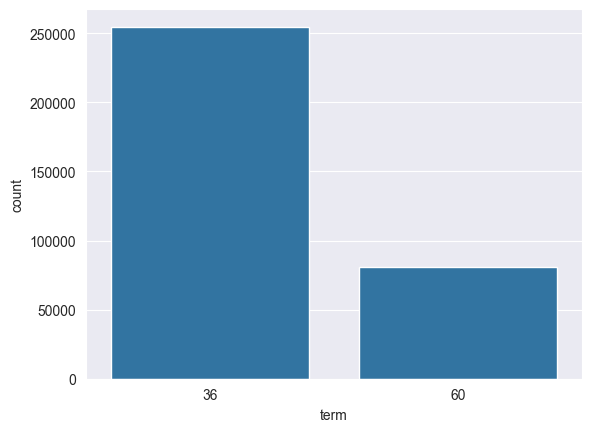

In [107]:
sns.countplot(x=df['term'],data=df)

In [85]:
df['emp_title'].unique() #Jako mnogo razlicitih klasa (verovatno droppovati)
df['home_ownership'].value_counts() #6 razlicitih vrednosti (dosta neizbalansirano)
# df['application_type'].value_counts() #3 razlicite vrednosti (dosta neizbalansirano)
# df['grade'].value_counts() #7 razlicitih vrednosti ok izbalansirano
# df['sub_grade'].value_counts() #35 razlicitih vrednosti dosta izbalansirano (mozda izbaciti ove, a zadrzati ocene i njih pretvoriti u brojeve)
# df['verification_status'].value_counts() #Izbalansirane vrednosti mozda ih preveseti od 1 do 3 vrednosti 

home_ownership
3    170831
2    133932
1     31045
Name: count, dtype: int64

In [126]:
df = df[df['home_ownership'].isin(['MORTGAGE', 'RENT', 'OWN'])]  # Zadržavamo samo ove vrednosti
df['home_ownership'] = df['home_ownership'].map({'MORTGAGE':3, 'RENT':2, 'OWN':1})

In [128]:
df['home_ownership'].value_counts() #Kolona resena

home_ownership
3    170831
2    133932
1     31045
Name: count, dtype: int64

In [129]:
df = df.drop(columns=['sub_grade']) # Dropovanje kolone sub_grade (previse kategorija)
df = df.drop(columns=['pub_rec']) # Dropovanje kolone pub_rec
df = df.drop(columns=['emp_title']) # Dropovanje kolone pub_rec emp_title

In [130]:
df.head()   #Izbacene tri kolone iznad

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36,11.44,329.48,B,10+ years,2,117000.0,Not Verified,Jan-2015,...,Jun-1990,16.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36,11.99,265.68,B,4 years,3,65000.0,Not Verified,Jan-2015,...,Jul-2004,17.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36,10.49,506.97,B,< 1 year,2,43057.0,Source Verified,Jan-2015,...,Aug-2007,13.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36,6.49,220.65,A,6 years,2,54000.0,Not Verified,Nov-2014,...,Sep-2006,6.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60,17.27,609.33,C,9 years,3,55000.0,Verified,Apr-2013,...,Mar-1999,13.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [132]:
#Za mapiranje 
df['application_type'].value_counts() #3 razlicite vrednosti (dosta neizbalansirano)
# df['grade'].value_counts() #7 razlicitih vrednosti ok izbalansirano
# df['verification_status'].value_counts() #Izbalansirane vrednosti mozda ih preveseti od 1 do 3 vrednosti
# loan_status 0 - Fully Charged     1 - Charged off 
# Sta raditi sa kolonom "issue_d"?

application_type
INDIVIDUAL    335252
JOINT            311
DIRECT_PAY       245
Name: count, dtype: int64

In [133]:
mapa_application_type = {'INDIVIDUAL':1, 'JOINT':2, 'DIRECT_PAY':3}
df['application_type'] = df['application_type'].map(mapa_application_type)

In [136]:
grades_mapa = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5,'F':6,'G':7}
verification_mapa = {'Source Verified':1, 'Verified':2, 'Not Verified':3}
df['grade'] = df['grade'].map(grades_mapa)
df['verification_status'] = df['verification_status'].map(verification_mapa)

In [137]:
df.head()   #Prikaz svih mapiranih kolona

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36,11.44,329.48,2,10+ years,2,117000.0,3,Jan-2015,...,Jun-1990,16.0,36369.0,41.8,25.0,w,1,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36,11.99,265.68,2,4 years,3,65000.0,3,Jan-2015,...,Jul-2004,17.0,20131.0,53.3,27.0,f,1,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36,10.49,506.97,2,< 1 year,2,43057.0,1,Jan-2015,...,Aug-2007,13.0,11987.0,92.2,26.0,f,1,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36,6.49,220.65,1,6 years,2,54000.0,3,Nov-2014,...,Sep-2006,6.0,5472.0,21.5,13.0,f,1,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60,17.27,609.33,3,9 years,3,55000.0,2,Apr-2013,...,Mar-1999,13.0,24584.0,69.8,43.0,f,1,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [140]:
#Treba samo korigovati izlaznu kolonu
loan_status_mapa = {'Fully Paid':0, 'Charged Off':1}
df['loan_status'] = df['loan_status'].map(loan_status_mapa)

In [141]:
df['loan_status'].value_counts()

loan_status
0    269509
1     66299
Name: count, dtype: int64

In [142]:
#Ostale su kolone emp_length,issue_d, purpose, title, earliest_cr_line, initial_list_status, address

ValueError: could not convert string to float: '10+ years'

In [155]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36,11.44,329.48,2,10.0,2,117000.0,3,Jan-2015,...,Jun-1990,16.0,36369.0,41.8,25.0,w,1,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36,11.99,265.68,2,4.0,3,65000.0,3,Jan-2015,...,Jul-2004,17.0,20131.0,53.3,27.0,f,1,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36,10.49,506.97,2,1.0,2,43057.0,1,Jan-2015,...,Aug-2007,13.0,11987.0,92.2,26.0,f,1,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36,6.49,220.65,1,6.0,2,54000.0,3,Nov-2014,...,Sep-2006,6.0,5472.0,21.5,13.0,f,1,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60,17.27,609.33,3,9.0,3,55000.0,2,Apr-2013,...,Mar-1999,13.0,24584.0,69.8,43.0,f,1,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [145]:
df1 = df.copy()
df1['emp_length'] = df1['emp_length'].str.extract(r'(\d+)')  # Uzimamo samo brojeve

# Konvertujemo u float
df1['emp_length'] = df1['emp_length'].astype(float)

# Ako neka vrednost nije broj (npr. "< 1 year"), postavljamo je na 0
df1.loc[df1['emp_length'].isna(), 'emp_length'] = 0

AttributeError: Can only use .str accessor with string values!

In [146]:
df1['emp_length'].value_counts()    #iz nekog razloga je to uradjeno i na originalnom df ne znam tacno zasto ali ok

emp_length
10.0    115177
1.0      49973
2.0      31388
3.0      27442
5.0      22970
4.0      20318
7.0      18765
6.0      18382
8.0      17499
9.0      13894
Name: count, dtype: int64

In [162]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m-%d', errors='coerce')

In [163]:
df['issue_d'].value_counts()

issue_d
2014-10-01    14133
2014-07-01    12110
2015-01-01    11130
2013-12-01     9801
2013-11-01     9799
2015-07-01     9754
2013-10-01     9326
2015-04-01     9027
2014-01-01     8955
2013-09-01     8631
2014-04-01     8558
2013-08-01     8510
2014-05-01     8432
2014-11-01     8396
2013-07-01     8056
2015-05-01     7929
2015-10-01     7910
2014-03-01     7659
2014-08-01     7524
2013-06-01     7430
2014-06-01     7300
2013-05-01     7016
2014-02-01     6911
2015-03-01     6902
2015-02-01     6726
2015-08-01     6723
2013-04-01     6531
2015-06-01     6506
2015-12-01     5985
2013-03-01     5835
2015-11-01     5514
2013-02-01     5377
2016-03-01     5198
2015-09-01     5097
2013-01-01     4909
2012-11-01     4570
2012-10-01     4545
2012-09-01     4458
2012-12-01     4264
2014-09-01     4085
2012-08-01     3966
2016-02-01     3719
2016-01-01     3576
2012-07-01     3405
2014-12-01     3295
2012-06-01     2762
2016-04-01     2602
2012-05-01     2484
2012-04-01     2308
2016-06-01  

In [165]:
#Extractovanje iz kolone issue_d meseca i godine
df['issue_year'] = df['issue_d'].dt.year  # Ekstrahuj godinu
df['issue_month'] = df['issue_d'].dt.month  # Ekstrahuj mesec

In [166]:
#Dropovanje te kolone
df = df.drop(columns=['issue_d'])

In [167]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,issue_year,issue_month
0,10000.0,36,11.44,329.48,2,10.0,2,117000.0,3,0,...,36369.0,41.8,25.0,w,1,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",2015,1
1,8000.0,36,11.99,265.68,2,4.0,3,65000.0,3,0,...,20131.0,53.3,27.0,f,1,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",2015,1
2,15600.0,36,10.49,506.97,2,1.0,2,43057.0,1,0,...,11987.0,92.2,26.0,f,1,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113",2015,1
3,7200.0,36,6.49,220.65,1,6.0,2,54000.0,3,0,...,5472.0,21.5,13.0,f,1,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813",2014,11
4,24375.0,60,17.27,609.33,3,9.0,3,55000.0,2,1,...,24584.0,69.8,43.0,f,1,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650",2013,4


In [168]:
#Dropovanje adrese (previse cimanja oko analize)
df = df.drop(columns=['address'])

In [169]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,open_acc,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_year,issue_month
0,10000.0,36,11.44,329.48,2,10.0,2,117000.0,3,0,...,16.0,36369.0,41.8,25.0,w,1,0.0,0.0,2015,1
1,8000.0,36,11.99,265.68,2,4.0,3,65000.0,3,0,...,17.0,20131.0,53.3,27.0,f,1,3.0,0.0,2015,1
2,15600.0,36,10.49,506.97,2,1.0,2,43057.0,1,0,...,13.0,11987.0,92.2,26.0,f,1,0.0,0.0,2015,1
3,7200.0,36,6.49,220.65,1,6.0,2,54000.0,3,0,...,6.0,5472.0,21.5,13.0,f,1,0.0,0.0,2014,11
4,24375.0,60,17.27,609.33,3,9.0,3,55000.0,2,1,...,13.0,24584.0,69.8,43.0,f,1,1.0,0.0,2013,4


In [170]:
#Ostalo je da se rese kolone purpose, title, earliest_cr_line, initial_list_status

In [171]:
df['purpose'].value_counts() #Razmotriti

purpose
debt_consolidation    204292
credit_card            72613
home_improvement       19632
other                  16192
major_purchase          6367
small_business          3397
medical                 3239
car                     3074
moving                  2178
vacation                1956
house                   1713
wedding                  929
renewable_energy         225
educational                1
Name: count, dtype: int64

In [173]:
df['title'].value_counts() # ovo se droppuje
df = df.drop(columns=['title'])

In [174]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,open_acc,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_year,issue_month
0,10000.0,36,11.44,329.48,2,10.0,2,117000.0,3,0,...,16.0,36369.0,41.8,25.0,w,1,0.0,0.0,2015,1
1,8000.0,36,11.99,265.68,2,4.0,3,65000.0,3,0,...,17.0,20131.0,53.3,27.0,f,1,3.0,0.0,2015,1
2,15600.0,36,10.49,506.97,2,1.0,2,43057.0,1,0,...,13.0,11987.0,92.2,26.0,f,1,0.0,0.0,2015,1
3,7200.0,36,6.49,220.65,1,6.0,2,54000.0,3,0,...,6.0,5472.0,21.5,13.0,f,1,0.0,0.0,2014,11
4,24375.0,60,17.27,609.33,3,9.0,3,55000.0,2,1,...,13.0,24584.0,69.8,43.0,f,1,1.0,0.0,2013,4


In [176]:
df['initial_list_status'].value_counts()
df = df.drop(columns=['initial_list_status'])

In [177]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,issue_year,issue_month
0,10000.0,36,11.44,329.48,2,10.0,2,117000.0,3,0,...,Jun-1990,16.0,36369.0,41.8,25.0,1,0.0,0.0,2015,1
1,8000.0,36,11.99,265.68,2,4.0,3,65000.0,3,0,...,Jul-2004,17.0,20131.0,53.3,27.0,1,3.0,0.0,2015,1
2,15600.0,36,10.49,506.97,2,1.0,2,43057.0,1,0,...,Aug-2007,13.0,11987.0,92.2,26.0,1,0.0,0.0,2015,1
3,7200.0,36,6.49,220.65,1,6.0,2,54000.0,3,0,...,Sep-2006,6.0,5472.0,21.5,13.0,1,0.0,0.0,2014,11
4,24375.0,60,17.27,609.33,3,9.0,3,55000.0,2,1,...,Mar-1999,13.0,24584.0,69.8,43.0,1,1.0,0.0,2013,4


In [181]:
#Sredjivanje Purpose kolone
le = LabelEncoder()
df['purpose'] = le.fit_transform(df['purpose'])

In [184]:
df['purpose'].value_counts()

purpose
2     204292
1      72613
4      19632
9      16192
6       6367
11      3397
7       3239
0       3074
8       2178
12      1956
5       1713
13       929
10       225
3          1
Name: count, dtype: int64

In [185]:
#Ekstratovanjee datuma i meseca iz kolone earliest_cr_line
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%Y-%m-%d', errors='coerce')
df['earliest_cr_line_year'] = df['earliest_cr_line'].dt.year  # Ekstrahuj godinu
df['earliest_cr_line_month'] = df['earliest_cr_line'].dt.month  # Ekstrahuj mesec
df = df.drop(columns=['earliest_cr_line'])

In [187]:
df = df.drop(columns=['earliest_cr_line_year', 'earliest_cr_line_month']) #Ne vredi sjebao sam se i nmg da se bavim time vise

In [188]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,dti,open_acc,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,issue_year,issue_month
0,10000.0,36,11.44,329.48,2,10.0,2,117000.0,3,0,...,26.24,16.0,36369.0,41.8,25.0,1,0.0,0.0,2015,1
1,8000.0,36,11.99,265.68,2,4.0,3,65000.0,3,0,...,22.05,17.0,20131.0,53.3,27.0,1,3.0,0.0,2015,1
2,15600.0,36,10.49,506.97,2,1.0,2,43057.0,1,0,...,12.79,13.0,11987.0,92.2,26.0,1,0.0,0.0,2015,1
3,7200.0,36,6.49,220.65,1,6.0,2,54000.0,3,0,...,2.60,6.0,5472.0,21.5,13.0,1,0.0,0.0,2014,11
4,24375.0,60,17.27,609.33,3,9.0,3,55000.0,2,1,...,33.95,13.0,24584.0,69.8,43.0,1,1.0,0.0,2013,4


In [192]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,issue_year,issue_month
loan_amnt,1.000000,0.400511,0.152284,0.954390,0.164097,0.086617,0.143453,0.332252,-0.217544,0.062406,-0.140447,0.025591,0.182928,0.326293,0.096740,0.210960,0.006152,0.223555,-0.113086,0.062362,-0.023986
term,0.400511,1.000000,0.445205,0.158044,0.468077,0.058369,0.075854,0.055971,-0.191744,0.182061,-0.039649,0.090592,0.080883,0.085297,0.054951,0.102604,0.010510,0.097809,-0.016863,0.111182,-0.007317
int_rate,0.152284,0.445205,1.000000,0.143860,0.955610,0.002120,-0.066935,-0.072658,-0.129527,0.250724,0.161299,0.165535,-0.001004,-0.022236,0.272118,-0.045263,0.037206,-0.080862,0.048963,-0.045598,-0.004086
installment,0.954390,0.158044,0.143860,1.000000,0.144469,0.074202,0.119687,0.325696,-0.190657,0.041996,-0.123941,0.019785,0.170795,0.313497,0.119008,0.187999,0.007618,0.193981,-0.106841,0.025871,-0.023082
grade,0.164097,0.468077,0.955610,0.144469,1.000000,0.000865,-0.064646,-0.060232,-0.150270,0.263546,0.163458,0.171515,0.013375,-0.018541,0.232806,-0.029820,0.037623,-0.073392,0.057248,0.089621,-0.008037
emp_length,0.086617,0.058369,0.002120,0.074202,0.000865,1.000000,0.135313,0.059770,-0.012875,-0.019208,-0.014149,0.029222,0.029370,0.080621,0.036893,0.104532,-0.000588,0.200718,0.031891,0.006346,-0.001011
home_ownership,0.143453,0.075854,-0.066935,0.119687,-0.064646,0.135313,1.000000,0.128483,-0.001032,-0.056407,-0.036491,-0.020532,0.088058,0.108821,0.038395,0.155900,-0.000472,0.391116,-0.008345,-0.020203,-0.002678
annual_inc,0.332252,0.055971,-0.072658,0.325696,-0.060232,0.059770,0.128483,1.000000,-0.090143,-0.052934,0.012432,-0.186098,0.125949,0.298206,0.024775,0.184831,-0.010021,0.238540,-0.048542,0.053169,-0.007193
verification_status,-0.217544,-0.191744,-0.129527,-0.190657,-0.150270,-0.012875,-0.001032,-0.090143,1.000000,-0.072655,0.004400,-0.046677,-0.032922,-0.065406,-0.032509,-0.046812,-0.002288,-0.038604,-0.040995,-0.155625,0.006821
loan_status,0.062406,0.182061,0.250724,0.041996,0.263546,-0.019208,-0.056407,-0.052934,-0.072655,1.000000,0.024646,0.132839,0.029883,-0.012004,0.077502,-0.018627,0.003967,-0.072486,0.002652,0.044747,-0.018115


<Axes: xlabel='grade', ylabel='int_rate'>

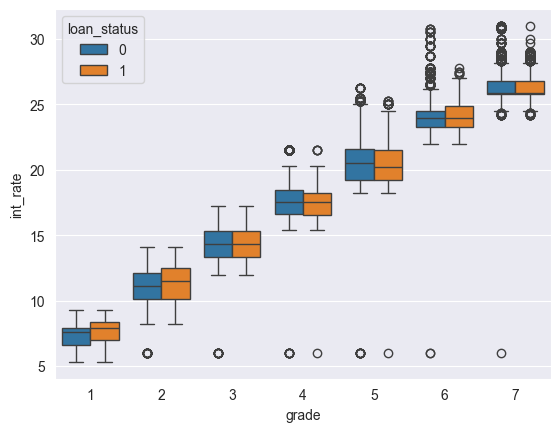

In [197]:
sns.boxplot(x='grade', y='int_rate', hue='loan_status', data=df)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,dti,open_acc,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,issue_year,issue_month
4,24375.0,60,17.27,609.33,3,9.0,3,55000.0,2,1,...,33.95,13.0,24584.0,69.8,43.0,1,1.0,0.0,2013,4
26,8400.0,36,13.35,284.45,3,6.0,2,35000.0,1,1,...,23.08,6.0,6953.0,74.8,17.0,1,0.0,0.0,2014,6
48,16000.0,60,18.54,411.01,5,3.0,2,40000.0,1,1,...,37.26,16.0,13179.0,55.6,20.0,1,0.0,0.0,2014,12
54,12000.0,60,8.18,244.36,2,7.0,3,60000.0,1,1,...,20.34,7.0,21750.0,59.9,20.0,1,1.0,0.0,2015,4
69,3350.0,36,15.61,117.14,4,10.0,3,52000.0,3,1,...,4.34,4.0,787.0,34.2,9.0,1,1.0,0.0,2014,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396000,10000.0,36,12.85,336.22,2,10.0,3,95000.0,1,1,...,15.35,9.0,5718.0,57.8,37.0,1,6.0,1.0,2014,1
396001,15000.0,60,15.61,361.67,4,10.0,3,47000.0,1,1,...,20.48,9.0,4621.0,55.0,15.0,1,1.0,0.0,2014,6
396002,17500.0,36,13.66,595.23,3,1.0,2,70000.0,1,1,...,19.08,22.0,16637.0,88.0,42.0,1,0.0,0.0,2015,1
396011,13000.0,36,10.99,425.55,2,10.0,2,56000.0,3,1,...,14.79,6.0,9964.0,64.3,23.0,1,3.0,0.0,2015,2


<Axes: xlabel='int_rate', ylabel='loan_amnt'>

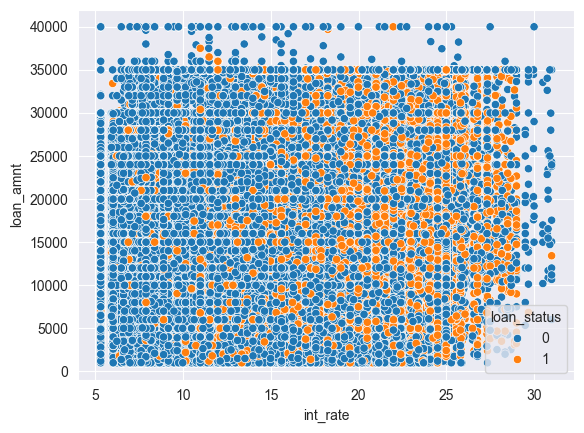

In [213]:
# test = df[df['loan_status']==1]
sns.scatterplot(data=df, x='int_rate', y='loan_amnt', hue='loan_status')

In [215]:
sns.pairplot(data=df)

Error in callback <function _draw_all_if_interactive at 0x0000023AAE74F380> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000023AE1EA4400> (for post_execute):


KeyboardInterrupt: 

In [222]:
#Treba sada izbalansirati ovaj skup podataka pre nego sto se krene sa normalizacijom i deljenjem podataka
df['loan_status'].value_counts()
#20% podataka ima  vrednost 1

loan_status
0    269509
1     66299
Name: count, dtype: int64

In [4]:
#Podela podataka na atribute i labele tj. ciljnu vrednost
X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values

NameError: name 'df' is not defined

In [232]:
#Podela na trening i test podatke + SMOTE + normalizacija
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train,y_train)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) #Ovo su podaci koje je prethodno obradio smote
X_test = scaler.transform(X_test)

In [269]:
X_train.shape
y_train == 1

array([ True, False, False, ...,  True,  True,  True])

In [248]:
#Treniranje modela
model = Sequential()

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))


#Output layer menjamo aktivacionu funkciju na sigmoidnu jer je ovo binarna klasifikacija s tim u vidu mozemo na izlazu da ocekujemo samo 0 ili 1
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')

In [239]:
help(EarlyStopping)

Help on class EarlyStopping in module keras.src.callbacks.early_stopping:

class EarlyStopping(keras.src.callbacks.callback.Callback)
 |  EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0)
 |
 |  Stop training when a monitored metric has stopped improving.
 |
 |  Assuming the goal of a training is to minimize the loss. With this, the
 |  metric to be monitored would be `'loss'`, and mode would be `'min'`. A
 |  `model.fit()` training loop will check at end of every epoch whether
 |  the loss is no longer decreasing, considering the `min_delta` and
 |  `patience` if applicable. Once it's found no longer decreasing,
 |  `model.stop_training` is marked True and the training terminates.
 |
 |  The quantity to be monitored needs to be available in `logs` dict.
 |  To make it so, pass the loss or metrics at `model.compile()`.
 |
 |  Args:
 |      monitor: Quantity to be monitored. Defaults to `"val

In [251]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1,mode='min')

In [252]:
model.fit(x=X_train, y=y_train, epochs=200,batch_size=512,validation_data=(X_test,y_test),callbacks=[early_stopping] ,verbose=1)

Epoch 1/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6879 - val_loss: 0.6292
Epoch 2/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6238 - val_loss: 0.6460
Epoch 3/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6085 - val_loss: 0.6153
Epoch 4/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6055 - val_loss: 0.6102
Epoch 5/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5994 - val_loss: 0.6032
Epoch 6/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5974 - val_loss: 0.6014
Epoch 7/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5946 - val_loss: 0.6142
Epoch 8/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5926 - val_loss: 0.6037
Epoch 9/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5920 - val_loss: 0.5921
Epoch 10/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5914 - val_loss: 0.6341
Epoch 11/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5881 - val_loss: 0.5928
Epoch 12/200
738/738 ━━━━━━━━━━━━━━━━━━━━

<Axes: >

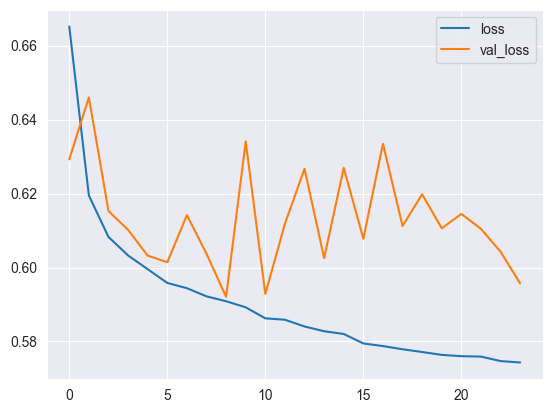

In [253]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [255]:
#Rekreiranje modela
#Treniranje modela
model = Sequential()

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))


#Output layer menjamo aktivacionu funkciju na sigmoidnu jer je ovo binarna klasifikacija s tim u vidu mozemo na izlazu da ocekujemo samo 0 ili 1
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')

In [256]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
model.fit(x=X_train, y=y_train, epochs=200, batch_size=512, validation_data=(X_test, y_test),
          callbacks=[early_stopping], verbose=1)

Epoch 1/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6861 - val_loss: 0.6380
Epoch 2/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6294 - val_loss: 0.6356
Epoch 3/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6155 - val_loss: 0.6301
Epoch 4/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6098 - val_loss: 0.6335
Epoch 5/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6059 - val_loss: 0.6241
Epoch 6/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6006 - val_loss: 0.6448
Epoch 7/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6000 - val_loss: 0.6385
Epoch 8/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5986 - val_loss: 0.6321
Epoch 9/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5954 - val_loss: 0.6515
Epoch 10/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5959 - val_loss: 0.6396
Epoch 11/200
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5931 - val_loss: 0.6314
Epoch 12/200
738/738 ━━━━━━━━━━━━━━━━━━━━

In [257]:
#Rekreiranje modela
#Treniranje modela
model = Sequential()

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))

#Output layer menjamo aktivacionu funkciju na sigmoidnu jer je ovo binarna klasifikacija s tim u vidu mozemo na izlazu da ocekujemo samo 0 ili 1
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
model.fit(x=X_train, y=y_train, epochs=400, batch_size=64, validation_data=(X_test, y_test),
          callbacks=[early_stopping], verbose=1)

Epoch 1/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.6098 - val_loss: 0.6424
Epoch 2/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.5520 - val_loss: 0.7711
Epoch 3/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.5320 - val_loss: 1.0647
Epoch 4/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.5243 - val_loss: 0.9692
Epoch 5/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.5193 - val_loss: 0.9975
Epoch 6/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5156 - val_loss: 1.1334
Epoch 7/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.5105 - val_loss: 1.2995
Epoch 8/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.5057 - val_loss: 0.9970
Epoch 9/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.5037 - val_loss: 0.8981
Epoch 10/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5026 - val_loss: 1.4411
Epoch 11/400
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.5011 - val_loss: 1.1769
Epoch 12

<Axes: >

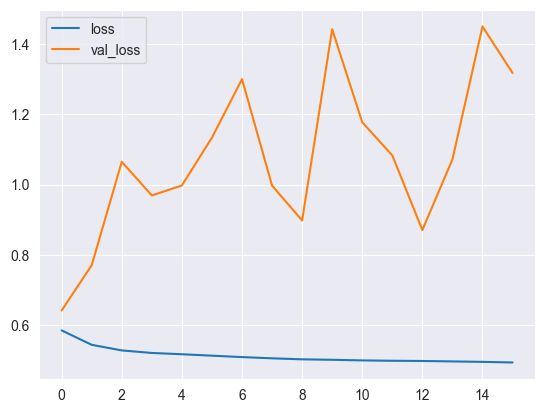

In [259]:
losses= pd.DataFrame(model.history.history)
losses.plot()

In [260]:
#Rekreiranje modela 4
#Treniranje modela 4
model = Sequential()

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.35))


#Output layer menjamo aktivacionu funkciju na sigmoidnu jer je ovo binarna klasifikacija s tim u vidu mozemo na izlazu da ocekujemo samo 0 ili 1
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min')
model.fit(x=X_train, y=y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test),
          callbacks=[early_stopping], verbose=1)

Epoch 1/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.6486 - val_loss: 0.6136
Epoch 2/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6048 - val_loss: 0.5687
Epoch 3/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5865 - val_loss: 0.6127
Epoch 4/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5748 - val_loss: 0.6323
Epoch 5/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5662 - val_loss: 0.6047
Epoch 6/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5618 - val_loss: 0.5856
Epoch 7/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5577 - val_loss: 0.5730
Epoch 8/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5546 - val_loss: 0.5529
Epoch 9/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.5516 - val_loss: 0.5628
Epoch 10/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5497 - val_loss: 0.5620
Epoch 11/200
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.5473 - val_loss: 0.5690
Epoch 12/

<Axes: >

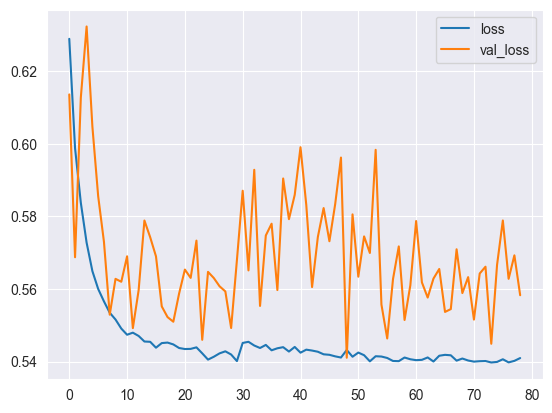

In [261]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [272]:
#Proba sa XGBBoost i i RandomForest
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [262]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred)) 

3149/3149 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step
              precision    recall  f1-score   support

           0       0.87      0.76      0.81     80814
           1       0.35      0.52      0.42     19929

    accuracy                           0.71    100743
   macro avg       0.61      0.64      0.62    100743
weighted avg       0.76      0.71      0.73    100743

[[61522 19292]
 [ 9504 10425]]


In [264]:
print(61522 + 10425)
print(9504 + 19292)

71947
28796


In [265]:
print(71947+28796)

100743


In [266]:
100743*0.25

25185.75

In [274]:
y_pred_xgb = xgb.predict(X_test)
y_pred_rfc = rfc.predict(X_test)

In [276]:
print(classification_report(y_test,y_pred_xgb))
print(confusion_matrix(y_test,y_pred_xgb)) 
print('------------------------------------------')
print(classification_report(y_test,y_pred_rfc))
print(confusion_matrix(y_test,y_pred_rfc)) 

#Bolji su od VNM bez podesavanja hiperparametara dosta

              precision    recall  f1-score   support

           0       0.82      0.96      0.89     80814
           1       0.49      0.17      0.25     19929

    accuracy                           0.80    100743
   macro avg       0.66      0.56      0.57    100743
weighted avg       0.76      0.80      0.76    100743

[[77333  3481]
 [16527  3402]]
------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     80814
           1       0.52      0.12      0.20     19929

    accuracy                           0.80    100743
   macro avg       0.67      0.55      0.54    100743
weighted avg       0.76      0.80      0.75    100743

[[78517  2297]
 [17457  2472]]


In [3]:
#Paralelno plotovanje metrika
print(f"Precision VNM",precision_score(y_test, y_pred))
print(f"Precision RFC",precision_score(y_test, y_pred_rfc))
print(f"Precision XGB",precision_score(y_test, y_pred_xgb))
preciznosti = np.array(precision_score(y_test, y_pred),precision_score(y_test, y_pred_rfc),precision_score(y_test, y_pred_xgb))
preciznosti = pd.DataFrame(preciznosti)
preciznosti.plot()

NameError: name 'y_test' is not defined

In [ ]:
#S obzirom da ucenje nije proslo kako sam se nadao treba usloziti podatke i usloziti model
#Ponovo prolaz kroz podatke i ponovno ucitavanje podataka
#Podaci su ocisceni tako da nema praznih kolona
#Ponovo plotujemo, analiziramo i sklanjamo nebitne kolone i trazimo neke relacije


In [5]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


<Axes: xlabel='purpose', ylabel='count'>

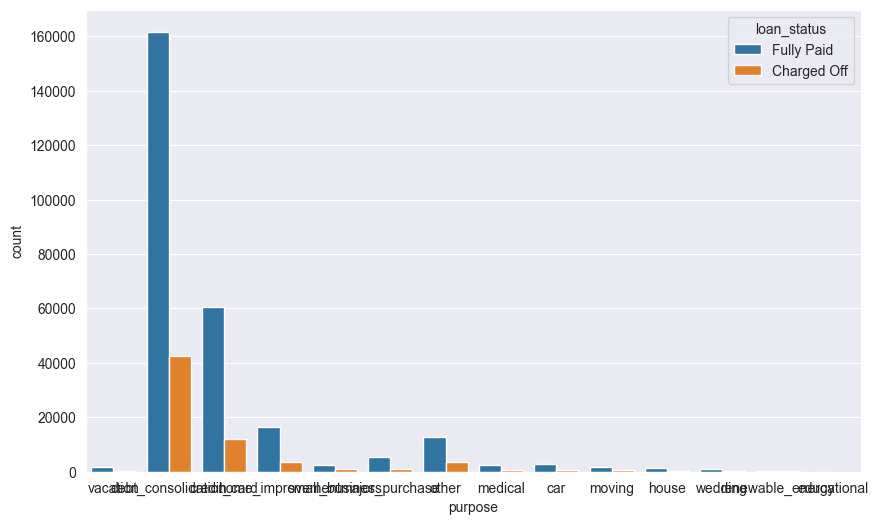

In [21]:
#sns.scatterplot(x='int_rate', y='loan_amnt', data=df, hue='loan_status')
#sns.countplot(x='grade', data=df, hue='loan_status')
plt.figure(figsize=(10,6))
#soritrane_subgrades = sorted(df['sub_grade'].unique())
# sns.countplot(x='sub_grade', data=df,order=soritrane_subgrades, hue='loan_status')
#sns.countplot(x='sub_grade',data=df,order = soritrane_subgrades, hue='loan_status')

#sns.countplot(x='emp_length', data=df, hue='loan_status') #Najvise pare uzimaju oni koji su najduze zaposleni s tim u vidu logicno oni i najcesce ne vrate. 
sns.countplot(x='purpose', data=df, hue='loan_status')


In [144]:
#Operacije na kolonama
df['term'] = df['term'].apply(lambda x: int(x.split()[0])) #Pretvaranje kolone term u brojeve 

df = df.drop(columns=['address', 'title','initial_list_status', 'emp_title', 'pub_rec'])

# df = df[df['home_ownership'].isin(['MORTGAGE', 'RENT', 'OWN'])]  # Zadržavamo samo ove vrednosti
# df['home_ownership'] = df['home_ownership'].map({'MORTGAGE':3, 'RENT':2, 'OWN':1})

# mapa_application_type = {'INDIVIDUAL': 1, 'JOINT': 2, 'DIRECT_PAY': 3}
# df['application_type'] = df['application_type'].map(mapa_application_type)
# grades_mapa = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
# verification_mapa = {'Source Verified': 1, 'Verified': 2, 'Not Verified': 3}
# df['grade'] = df['grade'].map(grades_mapa)
# df['verification_status'] = df['verification_status'].map(verification_mapa)

le = LabelEncoder()
#Pomocu label Encodera transformisemo ove kolone u brojeve
df['purpose'] = le.fit_transform(df['purpose'])
df['application_type'] = le.fit_transform(df['application_type'])
df['grade'] = le.fit_transform(df['grade'])
df['verification_status'] = le.fit_transform(df['verification_status'])
df['home_ownership'] = le.fit_transform(df['home_ownership'])

In [83]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
df['issue_year'] = df['issue_d'].dt.year  # Ekstrahuj godinu
df['issue_month'] = df['issue_d'].dt.month  # Ekstrahuj mesec
#Dropovanje te kolone

In [145]:
df.head()
df = df.drop(columns=['issue_d'])
#df['issue_d'].value_counts()

In [38]:
#Ovo je bio samo test
df1 = df.copy()
df1['emp_length'] = df1['emp_length'].str.extract(r'(\d+)')  # Uzimamo samo brojeve
# Konvertujemo u float
df1['emp_length'] = df1['emp_length'].astype(float)
# Ako neka vrednost nije broj (npr. "< 1 year"), postavljamo je na 0
df1.loc[df1['emp_length'].isna(), 'emp_length'] = 0

In [146]:

# df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
# df['earliest_cr_line_year'] = df['earliest_cr_line'].dt.year  # Ekstrahuj godinu
# df['earliest_cr_line_month'] = df['earliest_cr_line'].dt.month  # Ekstrahuj mesec
df = df.drop(columns=['earliest_cr_line'])
# df = df.drop(
#     columns=['earliest_cr_line_year', 'earliest_cr_line_month'])  #Ne vredi sjebao sam se i nmg da se bavim time vise


In [147]:
df['emp_length'] = df['emp_length'].str.extract(r'(\d+)')  # Uzimamo samo brojeve
# Konvertujemo u float
df['emp_length'] = df['emp_length'].astype(float)
# Ako neka vrednost nije broj (npr. "< 1 year"), postavljamo je na 0
df.loc[df['emp_length'].isna(), 'emp_length'] = 0

In [148]:
le = LabelEncoder()
df['sub_grade'] = le.fit_transform(df['sub_grade'])
loan_status_mapa = {'Fully Paid':0, 'Charged Off':1}
df['loan_status'] = df['loan_status'].map(loan_status_mapa)

In [149]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies
0,10000.0,36,11.44,329.48,1,8,10.0,5,117000.0,0,0,12,26.24,16.0,36369.0,41.8,25.0,1,0.0,0.0
1,8000.0,36,11.99,265.68,1,9,4.0,1,65000.0,0,0,2,22.05,17.0,20131.0,53.3,27.0,1,3.0,0.0
2,15600.0,36,10.49,506.97,1,7,1.0,5,43057.0,1,0,1,12.79,13.0,11987.0,92.2,26.0,1,0.0,0.0
3,7200.0,36,6.49,220.65,0,1,6.0,5,54000.0,0,0,1,2.60,6.0,5472.0,21.5,13.0,1,0.0,0.0
4,24375.0,60,17.27,609.33,2,14,9.0,1,55000.0,2,1,1,33.95,13.0,24584.0,69.8,43.0,1,1.0,0.0


In [159]:
#Ponovo delimo podatke
X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values

In [160]:
#Podela na trening i test podatke + SMOTE + normalizacija
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  #Ovo su podaci koje je prethodno obradio smote
X_test = scaler.transform(X_test)

In [102]:
y_train_br = pd.DataFrame(y_train)
y_train_br.value_counts()
#y_test.shape

0
0    188783
1    188783
Name: count, dtype: int64

In [161]:
#Ponovo kreiramo model
model = Sequential()

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))


#Output layer menjamo aktivacionu funkciju na sigmoidnu jer je ovo binarna klasifikacija s tim u vidu mozemo na izlazu da ocekujemo samo 0 ili 1
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

In [162]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min')
model.fit(x=X_train, y=y_train, epochs=200, batch_size=128, validation_data=(X_test, y_test),
          callbacks=[early_stopping], verbose=1)

Epoch 1/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6720 - val_loss: 0.5843
Epoch 2/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5817 - val_loss: 0.5777
Epoch 3/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5585 - val_loss: 0.5541
Epoch 4/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5441 - val_loss: 0.5638
Epoch 5/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5366 - val_loss: 0.5691
Epoch 6/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5275 - val_loss: 0.5437
Epoch 7/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5231 - val_loss: 0.5551
Epoch 8/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5193 - val_loss: 0.5363
Epoch 9/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5141 - val_loss: 0.5494
Epoch 10/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5120 - val_loss: 0.5734
Epoch 11/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5103 - val_loss: 0.5565
Epoch 12/200
2949/2

<Axes: >

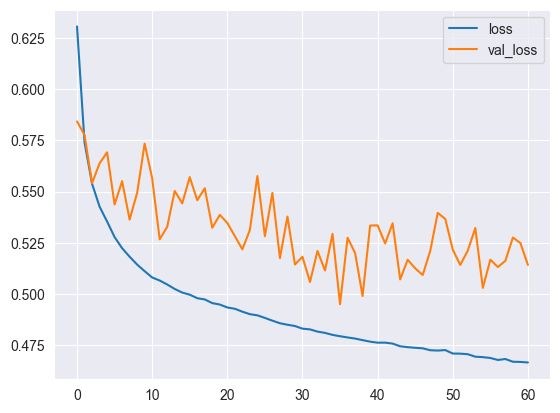

In [163]:
model_losses = pd.DataFrame(model.history.history)
model_losses.plot()

In [155]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred)) 

3149/3149 ━━━━━━━━━━━━━━━━━━━━ 3s 811us/step
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     80867
           1       0.39      0.33      0.36     19894

    accuracy                           0.77    100761
   macro avg       0.62      0.60      0.61    100761
weighted avg       0.75      0.77      0.76    100761

[[70469 10398]
 [13246  6648]]


In [157]:
print("Tacno procenjenjih:", 70469 + 6648)
print("Netacno procenjenih",10398 + 13246)
print("Procenat gresaka od ukupno procenjenih",(70469+6648+ 10398+ 13246))

Tacno procenjenjih: 77117
Netacno procenjenih 23644
Procenat gresaka od ukupno procenjenih 100761


In [164]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred)) 

3149/3149 ━━━━━━━━━━━━━━━━━━━━ 3s 819us/step
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     80867
           1       0.39      0.32      0.35     19894

    accuracy                           0.77    100761
   macro avg       0.62      0.60      0.61    100761
weighted avg       0.75      0.77      0.76    100761

[[71174  9693]
 [13576  6318]]


In [166]:
X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values
#Podela na trening i test podatke + SMOTE + normalizacija
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  #Ovo su podaci koje je prethodno obradio smote
X_test = scaler.transform(X_test)

In [167]:
model = Sequential()

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

#Output layer menjamo aktivacionu funkciju na sigmoidnu jer je ovo binarna klasifikacija s tim u vidu mozemo na izlazu da ocekujemo samo 0 ili 1
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

In [168]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [169]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min')
model.fit(x=X_train, y=y_train, epochs=200, batch_size=128, validation_data=(X_test, y_test),
          class_weight=class_weight_dict, verbose=1)

Epoch 1/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6653 - loss: 0.6756 - val_accuracy: 0.6333 - val_loss: 0.6635
Epoch 2/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7226 - loss: 0.5799 - val_accuracy: 0.6977 - val_loss: 0.5928
Epoch 3/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7341 - loss: 0.5563 - val_accuracy: 0.6934 - val_loss: 0.5947
Epoch 4/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7399 - loss: 0.5417 - val_accuracy: 0.6973 - val_loss: 0.5929
Epoch 5/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7450 - loss: 0.5311 - val_accuracy: 0.7209 - val_loss: 0.5731
Epoch 6/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7488 - loss: 0.5230 - val_accuracy: 0.7176 - val_loss: 0.5731
Epoch 7/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7499 - loss: 0.5179 - val_accuracy: 0.7421 - val_loss: 0.5427
Epoch 8/200
2949/2949 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7527 - loss: 0

<Axes: >

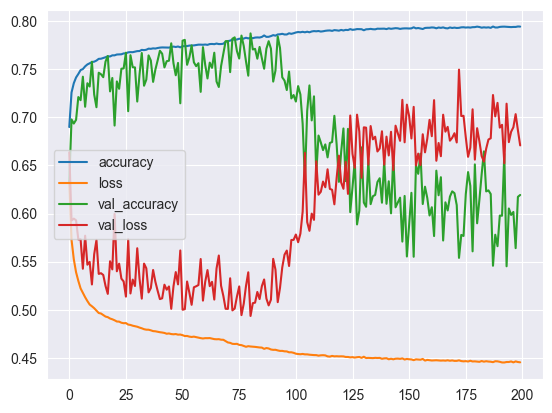

In [170]:
model_loss1 = pd.DataFrame(model.history.history)
model_loss1.plot() #jasno se vidi overfitting i da fali earlystopping

In [171]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred)) 

3149/3149 ━━━━━━━━━━━━━━━━━━━━ 2s 770us/step
              precision    recall  f1-score   support

           0       0.84      0.65      0.73     80867
           1       0.26      0.49      0.34     19894

    accuracy                           0.62    100761
   macro avg       0.55      0.57      0.53    100761
weighted avg       0.72      0.62      0.65    100761

[[52692 28175]
 [10190  9704]]
